In [1]:


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from evaluation import (
    n_precision_at_recall_for_query,
    precision_at_recall_for_query,
    tnr_at_recall_for_query,
    find_last_relevant_for_query,
    average_precision_for_query,
    sqrt_n_precision_at_recall_for_query,
)

%matplotlib inline

In [8]:
np.random.seed(42)

In [48]:
def generate_slr(dataset_id: str, percentage_relevant: float, dataset_size: int) -> dict:
    """generate dummy topic (SLR) with a given percentage of relevant documents"""
    n_relevant = int(percentage_relevant * dataset_size)
    n_irrelevant = dataset_size - n_relevant
    relevant = np.ones(n_relevant)
    irrelevant = np.zeros(n_irrelevant)

    dataset = {}
    for item_id, item in enumerate(np.concatenate([relevant, irrelevant])):
        dataset[str(item_id)] = int(item)

    return dataset

In [125]:
def generate_collection(n_topics, percent_relevant: float) -> tuple[dict, dict]:
    qrels = {}
    qrels_stats = {}
    deviation_rate = 0.05  # +/-5% deviation from the target percentage of relevant documents
    for topic_id in range(n_topics):
        size = np.random.randint(100, 1000)
        percentage_relevant = percent_relevant + np.random.random() * 2 * deviation_rate - deviation_rate
        topic_name = f'SLR_{topic_id}'
        qrels[topic_name] = generate_slr(dataset_id=topic_name, percentage_relevant=percentage_relevant,
                                         dataset_size=size)
        qrels_stats[topic_name] = {
            'size': size,
            'percentage_relevant': percentage_relevant
        }
    return qrels, qrels_stats

In [105]:
def generate_run(qrels: dict[str, dict[str, int]], recall_target: str):
    """generate a run that returns first recall_target of relevant documents and then all remaining documents in a random order"""
    run = {}
    deviation_rate = 0.05  # +/-2% deviation from the target percentage of recall_target relevant documents
    for topic_name, qrels_dict in qrels.items():
        n_relevant = sum(qrels_dict.values())
        n_relevant_target = int(n_relevant * recall_target + np.random.random() * 2 * deviation_rate - deviation_rate)
        run[topic_name] = {}
        current_relevant = 0
        relevance_score = len(qrels_dict)
        for item_id, item_relevance in qrels_dict.items():
            # add relevant documents until current_relevant == n_relevant_target
            # decrease relevance_score by 1 for each relevant document
            # then add all remaining documents shuffled in a random order
            run[topic_name][item_id] = relevance_score
            relevance_score -= 1
            current_relevant += 1
            if current_relevant == n_relevant_target:
                break
        remaining_items = list(qrels_dict.keys())  # minus the items already in the run
        remaining_items = [item for item in remaining_items if item not in run[topic_name].keys()]
        np.random.shuffle(remaining_items)
        for item_id in remaining_items:
            run[topic_name][item_id] = relevance_score
            relevance_score -= 1

    return run

In [56]:
qrels, qrels_stats = generate_collection(40, 0.5)

In [52]:
qrels['SLR_0']

{'0': 1,
 '1': 1,
 '2': 1,
 '3': 1,
 '4': 1,
 '5': 1,
 '6': 1,
 '7': 1,
 '8': 1,
 '9': 1,
 '10': 1,
 '11': 1,
 '12': 1,
 '13': 1,
 '14': 1,
 '15': 1,
 '16': 1,
 '17': 1,
 '18': 1,
 '19': 1,
 '20': 1,
 '21': 1,
 '22': 1,
 '23': 1,
 '24': 1,
 '25': 1,
 '26': 1,
 '27': 1,
 '28': 1,
 '29': 1,
 '30': 1,
 '31': 1,
 '32': 1,
 '33': 1,
 '34': 1,
 '35': 1,
 '36': 1,
 '37': 1,
 '38': 1,
 '39': 1,
 '40': 1,
 '41': 1,
 '42': 1,
 '43': 1,
 '44': 1,
 '45': 1,
 '46': 1,
 '47': 1,
 '48': 1,
 '49': 1,
 '50': 1,
 '51': 1,
 '52': 1,
 '53': 1,
 '54': 1,
 '55': 1,
 '56': 1,
 '57': 1,
 '58': 1,
 '59': 1,
 '60': 1,
 '61': 1,
 '62': 1,
 '63': 1,
 '64': 1,
 '65': 1,
 '66': 1,
 '67': 1,
 '68': 1,
 '69': 1,
 '70': 1,
 '71': 1,
 '72': 1,
 '73': 1,
 '74': 1,
 '75': 1,
 '76': 1,
 '77': 1,
 '78': 1,
 '79': 1,
 '80': 1,
 '81': 1,
 '82': 1,
 '83': 1,
 '84': 0,
 '85': 0,
 '86': 0,
 '87': 0,
 '88': 0,
 '89': 0,
 '90': 0,
 '91': 0,
 '92': 0,
 '93': 0,
 '94': 0,
 '95': 0,
 '96': 0,
 '97': 0,
 '98': 0,
 '99': 0,
 '100': 0,

In [58]:
runs = {}
for run_recall in range(1, 11):
    run = generate_run(qrels, run_recall / 10)
    runs[f'run_{run_recall}'] = run

In [59]:
runs

{'run_1': {'SLR_0': {'0': 655,
   '1': 654,
   '2': 653,
   '3': 652,
   '4': 651,
   '5': 650,
   '6': 649,
   '7': 648,
   '8': 647,
   '9': 646,
   '10': 645,
   '11': 644,
   '12': 643,
   '13': 642,
   '14': 641,
   '15': 640,
   '16': 639,
   '17': 638,
   '18': 637,
   '19': 636,
   '20': 635,
   '21': 634,
   '22': 633,
   '23': 632,
   '24': 631,
   '25': 630,
   '26': 629,
   '27': 628,
   '28': 627,
   '29': 626,
   '30': 625,
   '31': 624,
   '32': 623,
   '33': 622,
   '34': 621,
   '351': 620,
   '312': 619,
   '275': 618,
   '542': 617,
   '243': 616,
   '135': 615,
   '267': 614,
   '216': 613,
   '92': 612,
   '54': 611,
   '505': 610,
   '37': 609,
   '539': 608,
   '274': 607,
   '323': 606,
   '230': 605,
   '654': 604,
   '409': 603,
   '74': 602,
   '448': 601,
   '400': 600,
   '462': 599,
   '387': 598,
   '67': 597,
   '535': 596,
   '56': 595,
   '382': 594,
   '497': 593,
   '45': 592,
   '480': 591,
   '248': 590,
   '39': 589,
   '212': 588,
   '88': 587,
 

In [62]:
COLLECTION_SIZE = 50

In [112]:
df = pd.DataFrame()
for percentage_relevant in np.arange(0.1, 1, 0.1):
    qrels, qrels_stats = generate_collection(n_topics=COLLECTION_SIZE, percent_relevant=percentage_relevant)

    runs = {}
    for run_recall in np.arange(0.05, 1, 0.05):
        run = generate_run(qrels, run_recall)
        runs[f'run_{float(run_recall):.2f}'] = run

    for run_name, run in runs.items():
        scores_dict = {}
        print(run_name)
        for query_id, rankings in run.items():
            if len(rankings) != len(qrels[query_id]):
                # add missing documents at the end of the ranking with score -1000
                for doc_id in qrels[query_id].keys():
                    if doc_id not in rankings:
                        rankings[doc_id] = -1000

                # remove documents that are not in qrels
                rankings = {k: v for k, v in rankings.items() if k in qrels[query_id]}

            scores_dict[query_id] = {}
            # breakpoint()
            scores_dict[query_id]["model"] = run_name
            scores_dict[query_id][
                "model_recall_target"] = f"{float(run_name.split('_')[-1]):.2f}"  # change precision to 2 decimal places
            scores_dict[query_id]["dataset_percentage_relevant"] = percentage_relevant
            scores_dict[query_id]["dataset_true_percentage_relevant"] = qrels_stats[query_id]["percentage_relevant"]
            qrels_for_query = qrels[query_id]
            scores_dict[query_id]["nP@95%"] = n_precision_at_recall_for_query(
                rankings=rankings, qrels=qrels_for_query, recall_level=0.95
            )
            scores_dict[query_id]["P@95%"] = precision_at_recall_for_query(
                rankings=rankings, qrels=qrels_for_query, recall_level=0.95
            )
            scores_dict[query_id]["TNR@95%"] = tnr_at_recall_for_query(
                rankings=rankings, qrels=qrels_for_query, recall_level=0.95
            )
            scores_dict[query_id]["last_rel"] = find_last_relevant_for_query(
                rankings=rankings, qrels=qrels_for_query
            )
            scores_dict[query_id]["MAP"] = average_precision_for_query(
                rankings=rankings, qrels=qrels_for_query
            )
            scores_dict[query_id]["snP@95%"] = sqrt_n_precision_at_recall_for_query(
                rankings=rankings, qrels=qrels_for_query, recall_level=0.95
            )

            scores_dict[query_id]["Dataset size"] = len(rankings)
            scores_dict[query_id]["%Irrelevant"] = list(qrels_for_query.values()).count(
                0
            ) / len(qrels_for_query)
            scores_dict[query_id]["%Relevant"] = list(qrels_for_query.values()).count(
                1
            ) / len(qrels_for_query)
        print(len(df))
        df = pd.concat([df, pd.DataFrame(scores_dict).T])

run_0.05
0
run_0.10
50
run_0.15
100
run_0.20
150
run_0.25
200
run_0.30
250
run_0.35
300
run_0.40
350
run_0.45
400
run_0.50
450
run_0.55
500
run_0.60
550
run_0.65
600
run_0.70
650
run_0.75
700
run_0.80
750
run_0.85
800
run_0.90
850
run_0.95
900
run_0.05
950
run_0.10
1000
run_0.15
1050
run_0.20
1100
run_0.25
1150
run_0.30
1200
run_0.35
1250
run_0.40
1300
run_0.45
1350
run_0.50
1400
run_0.55
1450
run_0.60
1500
run_0.65
1550
run_0.70
1600
run_0.75
1650
run_0.80
1700
run_0.85
1750
run_0.90
1800
run_0.95
1850
run_0.05
1900
run_0.10
1950
run_0.15
2000
run_0.20
2050
run_0.25
2100
run_0.30
2150
run_0.35
2200
run_0.40
2250
run_0.45
2300
run_0.50
2350
run_0.55
2400
run_0.60
2450
run_0.65
2500
run_0.70
2550
run_0.75
2600
run_0.80
2650
run_0.85
2700
run_0.90
2750
run_0.95
2800
run_0.05
2850
run_0.10
2900
run_0.15
2950
run_0.20
3000
run_0.25
3050
run_0.30
3100
run_0.35
3150
run_0.40
3200
run_0.45
3250
run_0.50
3300
run_0.55
3350
run_0.60
3400
run_0.65
3450
run_0.70
3500
run_0.75
3550
run_0.80
3600
r

In [113]:
df.head()

model model_recall_target dataset_percentage_relevant  \
SLR_0  run_0.05                0.05                         0.1   
SLR_1  run_0.05                0.05                         0.1   
SLR_2  run_0.05                0.05                         0.1   
SLR_3  run_0.05                0.05                         0.1   
SLR_4  run_0.05                0.05                         0.1   

      dataset_true_percentage_relevant    nP@95%     P@95%   TNR@95%  \
SLR_0                         0.106652  0.003727  0.104589  0.035632   
SLR_1                         0.090832       1.0       1.0       1.0   
SLR_2                         0.067683  0.002725  0.067568  0.040334   
SLR_3                         0.083948  0.006547  0.084926  0.077088   
SLR_4                         0.086991  0.004101  0.085526  0.047945   

        last_rel       MAP   snP@95% Dataset size %Irrelevant %Relevant  
SLR_0  99.075026  0.155155  0.061047          973    0.894142  0.105858  
SLR_1   8.837209       1.0       1.0          215    0.911628  0.088372  
SLR_2   98.44358  0.113157  0.052204          771    0.932555  0.067445  
SLR_3  97.445972  0.169242  0.080912          509    0.917485  0.082515  
SLR_4  97.805643  0.132913  0.064036          319    0.915361  0.084639

In [114]:
metrics = ["nP@95%", "P@95%", "TNR@95%", "last_rel", "MAP", "snP@95%"]

In [115]:
grouped = df.groupby(['model', 'dataset_percentage_relevant'])[metrics].mean().reset_index()
grouped.head()

model  dataset_percentage_relevant    nP@95%     P@95%   TNR@95%  \
0  run_0.05                          0.1  0.125487  0.204183  0.177002   
1  run_0.05                          0.2    0.0322  0.216927  0.080668   
2  run_0.05                          0.3  0.017233  0.295923  0.057892   
3  run_0.05                          0.4  0.022035  0.405039  0.054333   
4  run_0.05                          0.5  0.025749  0.494909  0.051869   

    last_rel       MAP   snP@95%  
0  87.295585  0.251323  0.185897  
1  97.097699  0.276709  0.125606  
2   99.51207  0.360587  0.126951  
3  99.729019  0.464762   0.14591  
4  99.800285  0.554262  0.155047

In [97]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(grouped['recall_target'], grouped['nP@95%'], label='Mean nP@95%')
plt.plot(grouped['recall_target'], grouped['MAP'], label='Mean MAP')
plt.xlabel('Percentage Relevant')
plt.ylabel('Scores')
plt.title('Mean nP@95% and MAP Scores vs. Percentage Relevant by Recall Target')
plt.legend()
plt.grid(True)

plt.show()

KeyError: 'recall_target'

<Figure size 1000x600 with 0 Axes>

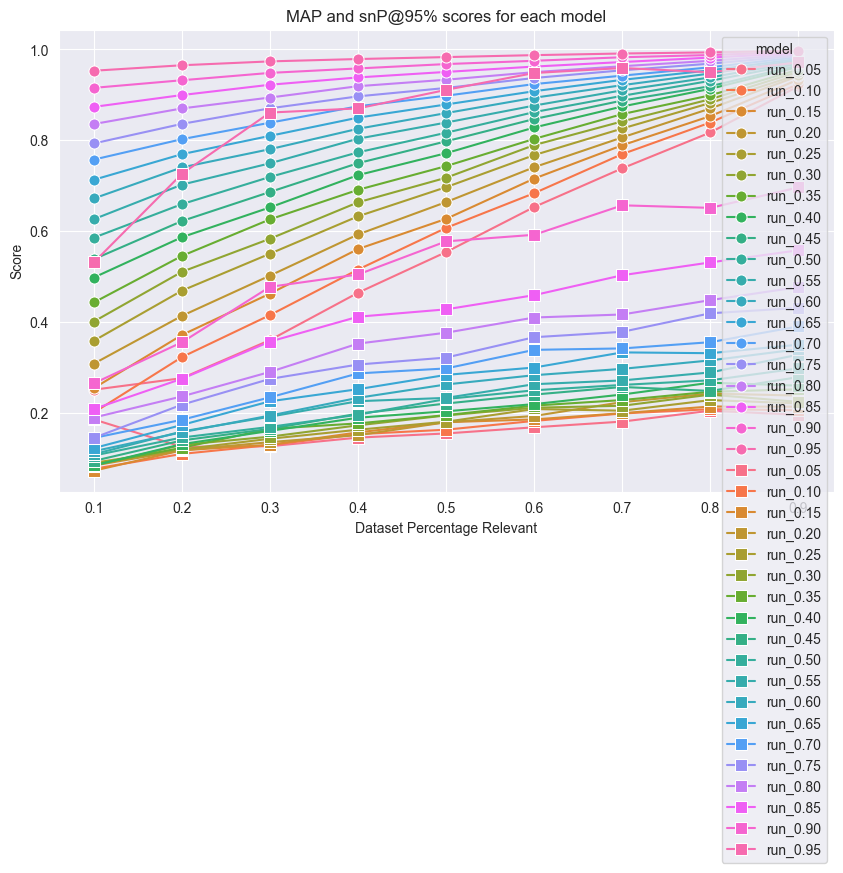

In [124]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='dataset_percentage_relevant', y='MAP', hue='model', data=grouped, marker='o', markersize=8)
sns.lineplot(x='dataset_percentage_relevant', y='snP@95%', hue='model', data=grouped, marker='s', markersize=8)
plt.title('MAP and snP@95% scores for each model')
plt.xlabel('Dataset Percentage Relevant')
plt.ylabel('Score')
# plt.legend() #off
# plt.legend(title='Model', loc='upper left')
plt.grid(True)
plt.show()


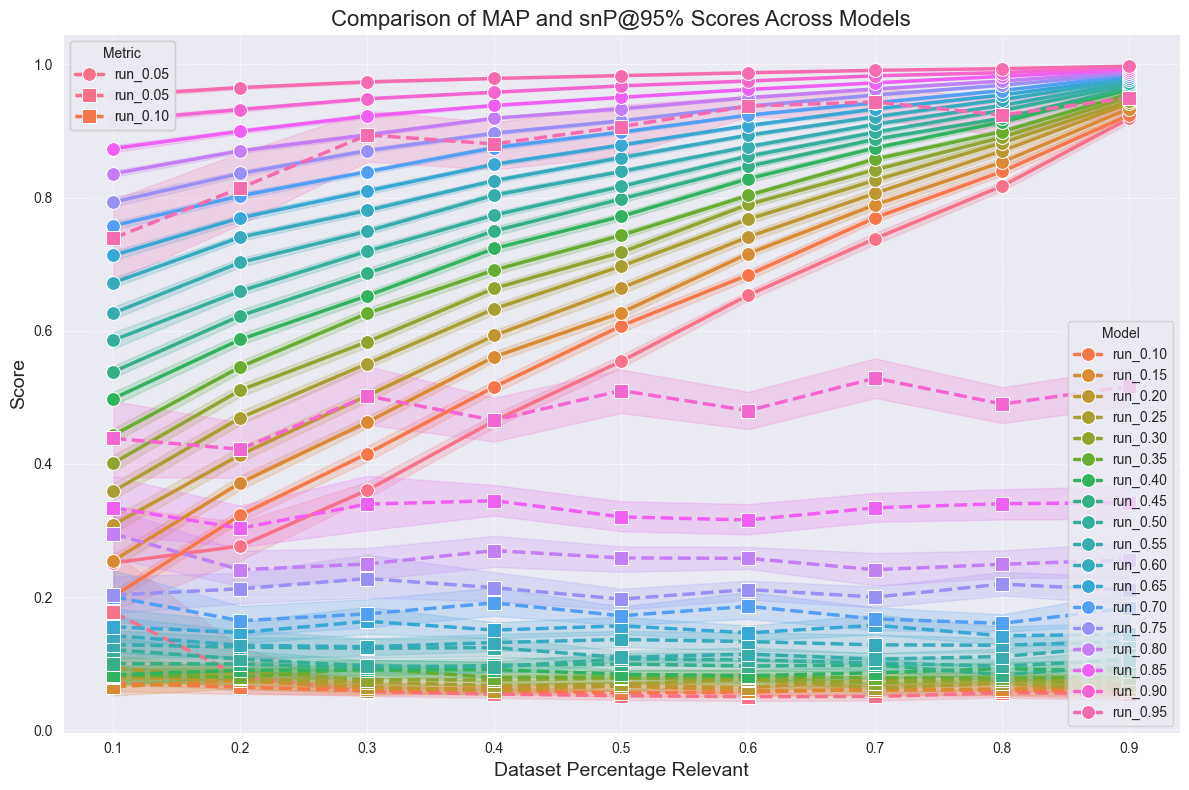

In [121]:
plt.figure(figsize=(12, 8))

# Plot MAP scores.
sns.lineplot(
    x='dataset_percentage_relevant',
    y='MAP',
    hue='model',
    data=df,
    marker='o',
    markersize=10,
    linewidth=2.5,
    linestyle='-'
)

# Plot snP@95% scores.
sns.lineplot(
    x='dataset_percentage_relevant',
    y='TNR@95%',
    hue='model',
    data=df,
    marker='s',
    markersize=10,
    linewidth=2.5,
    linestyle='--'
)

# Enhance the title and axis labels.
plt.title('Comparison of MAP and snP@95% Scores Across Models', fontsize=16)
plt.xlabel('Dataset Percentage Relevant', fontsize=14)
plt.ylabel('Score', fontsize=14)

# Enlarge the legend and place it outside the plot for clarity.
# plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
handles, labels = plt.gca().get_legend_handles_labels()

factor = int(len(handles) / 2)
new_handles = [handles[0]] + handles[factor:factor + 2]  # Adding only one handle per metric
new_labels = [labels[0]] + labels[factor:factor + 2]  # Adding only one label per metric

# Create the color legend for the models.
color_handles = handles[1:factor]
color_labels = labels[1:factor]
color_legend = plt.legend(color_handles, color_labels, loc='lower right', title='Model')

# Add the color legend manually.
plt.gca().add_artist(color_legend)

# Create and add the shape legend for metrics.
shape_legend = plt.legend(new_handles, new_labels, loc='upper left', title='Metric')
plt.gca().add_artist(shape_legend)

# Improve the grid for better reading.
plt.grid(which='both', linestyle='--', linewidth=0.5)

# Show the plot with all improvements.
plt.tight_layout()  # This will ensure the legend does not cut off.
plt.show()


# Correlation

In [118]:
print(
    df[
        [
            "nP@95%",
            "P@95%",
            "TNR@95%",
            "last_rel",
            "MAP",
            "snP@95%",
            "Dataset size",
            "%Irrelevant",
            "%Relevant",
        ]
    ]
    .corr("spearman")
    .round(3)
    # .to_latex()
)

              nP@95%  P@95%  TNR@95%  last_rel    MAP  snP@95%  Dataset size  \
nP@95%         1.000  0.671    0.804    -0.000  0.853    1.000         0.013   
P@95%          0.671  1.000    0.190     0.460  0.789    0.671         0.009   
TNR@95%        0.804  0.190    1.000    -0.387  0.600    0.804         0.006   
last_rel      -0.000  0.460   -0.387     1.000  0.135   -0.000         0.184   
MAP            0.853  0.789    0.600     0.135  1.000    0.853         0.007   
snP@95%        1.000  0.671    0.804    -0.000  0.853    1.000         0.013   
Dataset size   0.013  0.009    0.006     0.184  0.007    0.013         1.000   
%Irrelevant   -0.509 -0.936    0.006    -0.596 -0.658   -0.509        -0.012   
%Relevant      0.509  0.936   -0.006     0.596  0.658    0.509         0.012   

              %Irrelevant  %Relevant  
nP@95%             -0.509      0.509  
P@95%              -0.936      0.936  
TNR@95%             0.006     -0.006  
last_rel           -0.596      0.596  
MAP 

In [120]:
df[
    [
        "nP@95%",
        "P@95%",
        "TNR@95%",
        "last_rel",
        "MAP",
        "snP@95%",
        "Dataset size",
        "%Irrelevant",
        "%Relevant",
    ]
].corr("spearman").round(3)


nP@95%  P@95%  TNR@95%  last_rel    MAP  snP@95%  Dataset size  \
nP@95%         1.000  0.671    0.804    -0.000  0.853    1.000         0.013   
P@95%          0.671  1.000    0.190     0.460  0.789    0.671         0.009   
TNR@95%        0.804  0.190    1.000    -0.387  0.600    0.804         0.006   
last_rel      -0.000  0.460   -0.387     1.000  0.135   -0.000         0.184   
MAP            0.853  0.789    0.600     0.135  1.000    0.853         0.007   
snP@95%        1.000  0.671    0.804    -0.000  0.853    1.000         0.013   
Dataset size   0.013  0.009    0.006     0.184  0.007    0.013         1.000   
%Irrelevant   -0.509 -0.936    0.006    -0.596 -0.658   -0.509        -0.012   
%Relevant      0.509  0.936   -0.006     0.596  0.658    0.509         0.012   

              %Irrelevant  %Relevant  
nP@95%             -0.509      0.509  
P@95%              -0.936      0.936  
TNR@95%             0.006     -0.006  
last_rel           -0.596      0.596  
MAP                -0.658      0.658  
snP@95%            -0.509      0.509  
Dataset size       -0.012      0.012  
%Irrelevant         1.000     -1.000  
%Relevant          -1.000      1.000